In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.linear_model import LogisticRegression
from scipy.optimize import fmin_powell

%matplotlib inline

In [2]:
# simulate data

In [3]:
PRESIDENT_PROBABILITY = .01
ACCIDENT_PROBABILITY = .1
TRIALS = 100

In [4]:
president = np.random.binomial(n=1, p=PRESIDENT_PROBABILITY, size=TRIALS)
accident = np.random.binomial(n=1, p=ACCIDENT_PROBABILITY, size=TRIALS)

In [112]:
print( f'President Mean: {president.mean()}' )
print( f'Accident Mean: {accident.mean()}' )

President Mean: 0.03
Accident Mean: 0.08


In [6]:
traffic_probabilities = []
for president_observed, accident_observed in zip(president, accident):
    if not president_observed:
        probability = .5 if accident_observed else .1
    else:
        probability = .9 if accident_observed else .6
    traffic_probabilities.append( probability )
    
traffic = np.random.binomial(n=1, p=traffic_probabilities)

In [113]:
print( f'Traffic Mean: {traffic.mean()}')

Traffic Mean: 0.14


In [8]:
# probabilities are no longer fixed values, but distributions

In [9]:
times_president_observed = sum(president)
times_president_not_observed = len(president) - times_president_observed

president_probability_samples = np.random.beta(
    a=1 + times_president_observed, 
    b=1 + times_president_not_observed, 
    size=4567
)

In [10]:
times_accident_observed = sum(accident)
times_accident_not_observed = len(accident) - times_accident_observed

accident_probability_samples = np.random.beta(
    a=1 + times_accident_observed, 
    b=1 + times_accident_not_observed, 
    size=4567
)

In [11]:
# P(traffic | accident, president)

In [130]:
# logistic regression baseline

glm = LogisticRegression()
_ = glm.fit(X=observed_data[['president', 'accident']], y=observed_data['traffic'])

In [131]:
precision = 5
print( f'Estimated intercept: {glm.intercept_[0]:.{precision}}' )
print( f'Estimated president coefficient: {glm.coef_[0][0]:.{precision}}' )
print( f'Estimated accident coefficient: {glm.coef_[0][1]:.{precision}}' )

Estimated intercept: -1.8182
Estimated president coefficient: 0.4104
Estimated accident coefficient: 1.1995


In [151]:
observed_data = pd.DataFrame({'president': president, 'accident': accident, 'traffic': traffic})

with pm.Model() as model:
    pm.glm.glm('traffic ~ president + accident', observed_data, family=pm.glm.families.Binomial())
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
    step = pm.NUTS(scaling=start_MAP)
    traces = pm.sample(2000, step=step, njobs=2, progressbar=True)

100%|██████████| 2000/2000 [00:06<00:00, 316.88it/s]


In [143]:
# i'm not sure why, but everything seems to go to hell when i have `njobs=4`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15c0c03c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x164c0b860>]], dtype=object)

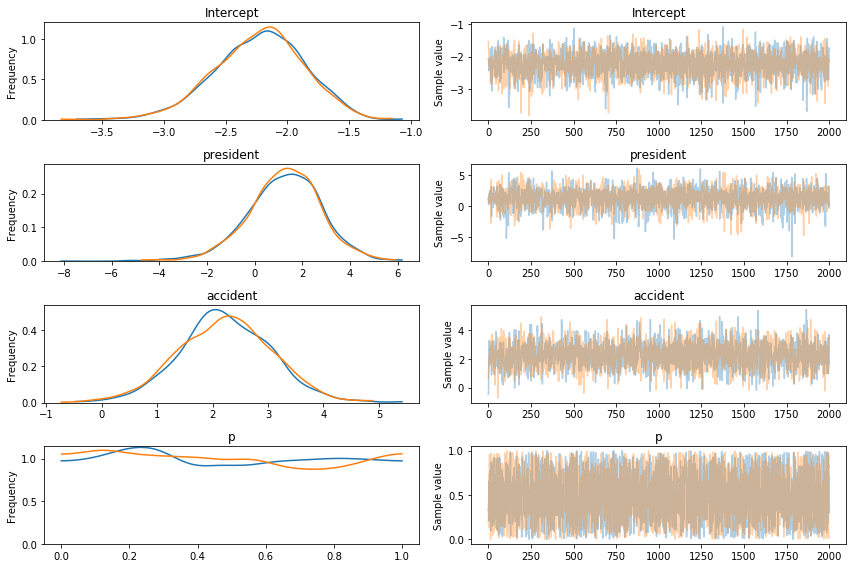

In [152]:
pm.traceplot(traces)

In [153]:
pm.summary(traces)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.232           0.365            0.007            [-2.947, -1.530]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.994         -2.464         -2.210         -1.983         -1.570


president:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.236            1.531            0.033            [-1.815, 4.234]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.926         0.311          1.310          2.276          4.174


accident:

  Mean             SD               MC Error         95% HPD interval
  ----------